# Predicción de la tendecia del ETF SPY

---

# 1. Objetivo Principal del Proyecto

Desarrollar y desplegar un modelo predictivo utilizando redes LSTM para predecir la tendencia diaria al alza (retornos positivos) del ETF SPY.

## 1.1. Conceptos generales

### 📈 SPY ETF y ETF
- Un ETF (Exchange-Traded Fund) es un fondo de inversión que cotiza en bolsa y permite a los inversores comprar y vender participaciones como si fueran acciones. Replica el desempeño de un índice, sector o activo, ofreciendo diversificación, liquidez y bajos costos operativos.
- SPY es un fondo cotizado (ETF) que replica el comportamiento del índice S&P 500.
- Cuando predices SPY, estás haciendo una especie de proxy del S&P 500.

### 📊 Predecir la tendencia diaria al alza
- El modelo no va a predecir el precio exacto del SPY.
- En su lugar, intentará determinar si el precio subirá o no al día siguiente (es decir, si el retorno será positivo).
- Esto se convierte en un problema de clasificación binaria:
  - **1** si el precio sube (retorno positivo).
  - **0** si el precio baja o se mantiene.

### 🧬 Redes LSTM (Long Short-Term Memory)
- Son un tipo de Red Neuronal Recurrente (RNN) especializada en aprender secuencias de datos temporales, como precios bursátiles.
- A diferencia de las RNN normales, las LSTM recuerdan información por más tiempo (memoria a largo plazo), lo cual es clave para detectar patrones en series temporales financieras.


## 1.2. ¿Por qué usar LSTM para esto?

En mercados financieros:
- El precio de hoy depende (en parte) del comportamiento de los días anteriores.
- Las LSTM pueden detectar patrones como tendencias, momentum, retrocesos, etc.



---


# 2. ¿Qué es el SPY? Explicación detallada

El **S&P 500** es un índice bursátil que refleja el desempeño de las 500 empresas más relevantes de Estados Unidos. Su comportamiento actúa como un indicador del estado general del mercado financiero en el país. Si estas empresas crecen y generan buenos resultados, el S&P 500 aumenta; si enfrentan dificultades, el índice disminuye.


## 2.1. ¿Qué representa el SPY?

El **SPY** es un fondo cotizado en bolsa (ETF) que replica exactamente los movimientos del S&P 500. Se trata de un instrumento financiero que permite a los inversores comprar y vender participaciones en el índice como si se tratara de una acción individual.

En términos simples:
- Si el **S&P 500** sube, el **SPY** también subirá.
- Si el **S&P 500** baja, el **SPY** reflejará esa caída.

Este ETF permite a los inversores obtener exposición al mercado estadounidense sin la necesidad de adquirir acciones de todas las empresas que conforman el índice.


## 2.2. ¿Cuál es la utilidad del SPY?

El SPY se utiliza principalmente como una forma sencilla y eficiente de invertir en el mercado de valores de EE.UU. sin tener que comprar individualmente las acciones de cada una de las 500 empresas del índice. Entre sus principales ventajas se encuentran:

- **Diversificación**: Al comprar SPY, el inversor obtiene exposición a múltiples sectores de la economía estadounidense.
- **Accesibilidad**: Se puede adquirir a través de plataformas de inversión de la misma manera que se compraría una acción de cualquier empresa.
- **Eficiencia**: Es una alternativa práctica para aquellos que buscan replicar el comportamiento del mercado sin realizar una selección individual de activos.

Además es uno de los ETFs más grandes y negociados del mundo debido a varias razones:
- **Alta liquidez**: Se compra y vende con facilidad, lo que lo hace atractivo para inversores activos y operadores de corto plazo.
- **Bajas comisiones**: En comparación con fondos de inversión tradicionales, sus costos de gestión son reducidos.
- **Transparencia**: Su composición es pública y sigue directamente el índice S&P 500 sin cambios arbitrarios en su estructura.


## 2.3. Relación entre SPY y el proyecto

El objetivo del proyecto es desarrollar un modelo basado en redes neuronales LSTM para predecir si el SPY aumentará su valor en la siguiente jornada de mercado. Dado que el SPY replica el comportamiento del S&P 500, esta predicción equivale a determinar si el mercado estadounidense en su conjunto tendrá una tendencia positiva en el próximo día de negociación.

---


# 3. Índice

El objetivo de este proyecto será desarrollar y desplegar un modelo predictivo utilizando redes LSTM para predecir la tendencia diaria al alza (retornos positivos) del ETF SPY.

Explciacion que es ETF , SPY, SP500, etc... porque hemos elegido esto, ventajas, desventajas, etc...

Estrucutra e indice del proyecto


# 4. Librerías

In [2]:
import numpy as np  # Numerical operations on arrays and matrices
import pandas as pd  # Data manipulation and analysis
import datetime  # Date and time manipulation
import random  # Generate random numbers and random selection
import pandas_datareader.data as web  # Fetch financial data from online sources
import matplotlib.pyplot as plt  # Data visualization and plotting
import seaborn as sns  # Statistical data visualization
import pandas_ta as ta  # Technical analysis indicators and tools
import statsmodels.api as sm  # Statistical modeling and econometrics
from alpha_vantage.timeseries import TimeSeries  # Fetch time series data from Alpha Vantage API
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Calculate Variance Inflation Factor (VIF) for multicollinearity analysis
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, roc_auc_score  # Model evaluation metrics
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification and feature importance
from scipy import stats  # Statistical functions and tests
from collections import defaultdict  # Dictionary subclass for counting and grouping
from minisom import MiniSom  # Self Organizing Maps for dimensionality reduction and clustering
import warnings
import yfinance as yf
warnings.filterwarnings('ignore') #ignore warnings 

In [ ]:
# pip install pandas_datareader pandas_ta statsmodels alpha_vantage minisom

# 5. Recolección de bases de datos

## 5.1 Datos Diarios del SPY

Este apartado automatiza la descarga, limpieza y preparación de datos diarios del ETF SPY desde Yahoo Finance, calculando rendimientos para análisis cuantitativo y modelado financiero.

In [7]:
# Define the ticker and date range
symbol = 'SPY'
start_date = '2018-02-01'
end_date = '2025-02-01'

# Download daily data from Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

data = data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adjusted_close',
    'Volume': 'volume'
})

# Select only the relevant columns
data = data[['open', 'high', 'low', 'close', 'adjusted_close', 'volume']]

# Calculate daily returns based on adjusted close
data['daily_return'] = data['adjusted_close'].pct_change()

# Drop the first row with NaN
data.dropna(inplace=True)

# Save the data to CSV
data.to_csv('SPY_Daily_Data.csv')
data.to_excel('SPY_Daily_Data.xlsx')

[*********************100%***********************]  1 of 1 completed


In [8]:
data

Price,open,high,low,close,adjusted_close,volume,daily_return
Ticker,SPY,SPY,SPY,SPY,SPY,SPY,
Date,,,,,,,
2018-02-02,280.079987,280.230011,275.410004,275.450012,245.220901,173174800,-0.021770
2018-02-05,273.450012,275.850006,263.309998,263.929993,234.965195,294681800,-0.041822
2018-02-06,259.940002,269.700012,258.700012,269.130005,239.594543,355026800,0.019702
2018-02-07,268.500000,272.359985,267.579987,267.670013,238.294693,167376100,-0.005425
2018-02-08,268.010010,268.170013,257.589996,257.630005,229.356552,246449500,-0.037509
...,...,...,...,...,...,...,...
2025-01-27,594.809998,599.690002,594.640015,599.369995,597.572388,70361100,-0.014145
2025-01-28,600.619995,605.369995,597.250000,604.520020,602.706970,44433300,0.008592


## 5.2 Tesorería FRED

Este script extrae datos diarios de los rendimientos de los bonos del Tesoro de EE.UU. a 2 y 10 años desde la API de FRED (Federal Reserve Economic Data) y calcula el diferencial de rendimiento (10 años - 2 años). 

El propósito de este conjunto de datos es análisis de la curva de rendimiento del Tesoro, un indicador clave en el análisis macroeconómico y financiero.

In [9]:
# Define the time range
start_date = '2018-02-01'
end_date = '2025-02-01'

# Fetch the daily 2-Year and 10-Year Treasury yields from FRED
dgs2 = web.DataReader('DGS2', 'fred', start_date, end_date)
dgs10 = web.DataReader('DGS10', 'fred', start_date, end_date)

# Combine the two datasets into a single DataFrame
treasury_data = pd.concat([dgs2, dgs10], axis=1)
treasury_data.columns = ['2yr_yield', '10yr_yield']

# Calculate the daily yield spread (10-Year minus 2-Year)
treasury_data['yield_spread'] = treasury_data['10yr_yield'] - treasury_data['2yr_yield']

# Drop any rows with missing values (optional)
treasury_data.dropna(inplace=True)

# Save the data to a CSV file
treasury_data.to_csv('Treasury_Yields.csv')

In [10]:
treasury_data

,2yr_yield,10yr_yield,yield_spread
DATE,,,
2018-02-01,2.16,2.78,0.62
2018-02-02,2.15,2.84,0.69
2018-02-05,2.08,2.77,0.69
2018-02-06,2.10,2.79,0.69
2018-02-07,2.15,2.84,0.69
...,...,...,...
2025-01-27,4.17,4.53,0.36
2025-01-28,4.19,4.55,0.36
2025-01-29,4.21,4.55,0.34


## 5.3 Precios ajustados y cálculo de rendimientos diarios

Este script automatiza la descarga de datos de precios ajustados y el cálculo de rendimientos diarios para una selección de activos financieros clave (VXX, GLD, UUP, USO, QQQ) desde Yahoo Finance.

El objetivo es generar un conjunto de datos para el análisis de correlaciones, construcción de carteras diversificadas y modelado de riesgos en mercados financieros.

---

## Utilidad de ['VXX', 'GLD', 'UUP', 'USO', 'QQQ'] en la Predicción del SPY con LSTM

En el contexto de este proyecto, la inclusión de los tickers ['VXX', 'GLD', 'UUP', 'USO', 'QQQ'] aporta información valiosa y mejorará el rendimiento del modelo.

### ¿Qué representan estos tickers?

* **VXX (iPath S&P 500 VIX Short-Term Futures ETN):**
    * Representa la volatilidad del mercado, funcionando como un "índice del miedo".
    * Suele tener correlación negativa con el SPY, útil para capturar cambios bruscos en el mercado.
* **GLD (SPDR Gold Shares):**
    * Sigue el precio del oro, un activo refugio en tiempos de incertidumbre.
    * Añade información sobre la percepción del riesgo y la inflación.
* **UUP (Invesco DB US Dollar Index Bullish Fund):**
    * Mide el valor del dólar frente a otras divisas.
    * Ayuda a considerar el impacto de factores macroeconómicos globales.
* **USO (United States Oil Fund LP):**
    * Sigue el precio del petróleo crudo.
    * Introduce la influencia de los precios de la energía en el mercado.
* **QQQ (Invesco QQQ Trust):**
    * Sigue el indice Nasdaq 100, y por lo tanto el sector tecnologico.
    * Este sector tiene una gran influencia en el SPY.

### ¿Por qué son útiles para un modelo LSTM?

1.  **Características exógenas:**
    * El SPY está influenciado por múltiples factores. Estos ETFs proporcionan información externa relevante.
    * El modelo LSTM puede aprender las relaciones entre estos activos y el SPY.
2.  **Captura de relaciones no lineales:**
    * Las relaciones entre el SPY y estos activos son complejas y no lineales.
    * Las LSTM son excelentes para modelar estas relaciones dinámicas.
3.  **Reducción del ruido:**
    * Estos ETFs ayudan a filtrar el "ruido" en los datos del SPY.
    * Permiten al modelo enfocarse en señales significativas.
4.  **Diversificación de información:**
    * Al tener datos de volatilidad, materias primas, divisas, y el sector tecnologico, se le entrega al modelo gran cantidad de información sobre el mercado.

In [56]:
# Define symbols and time range
symbols = ['VXX', 'GLD', 'UUP', 'USO', 'QQQ']
start_date = '2018-02-01'
end_date = '2025-02-01'

# Initialize DataFrame to collect all daily returns
all_data = pd.DataFrame()

# Loop through each symbol
for symbol in symbols:
    print(f'Downloading {symbol}...')
    
    # Download data with adjusted close included
    data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

    # Rename adjusted close to custom name
    data = data[['Adj Close']].rename(columns={'Adj Close': f'{symbol}_adj_close'})
    
    # Calculate daily return
    data[f'{symbol}_daily_return'] = data[f'{symbol}_adj_close'].pct_change()
    
    # Keep only the daily return column
    data = data[[f'{symbol}_daily_return']]
    
    # Merge into the master DataFrame
    if all_data.empty:
        all_data = data
    else:
        all_data = pd.merge(all_data, data, left_index=True, right_index=True, how='outer')

# Drop rows where all returns are NaN (e.g., holidays)
all_data.dropna(how='all', inplace=True)

# Save to CSV
all_data.to_csv('VXX_GLD_UUP_USO_QQQ_Daily_Returns.csv')
all_data.to_excel('VXX_GLD_UUP_USO_QQQ_Daily_Returns.xlsx')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [12]:
all_data

Price,VXX_daily_return,GLD_daily_return,UUP_daily_return,USO_daily_return,QQQ_daily_return
Ticker,,,,,
Date,,,,,
2018-02-02,0.128594,-0.013118,0.006053,-0.015106,-0.019945
2018-02-05,0.335160,0.002532,0.004298,-0.020705,-0.039426
2018-02-06,-0.016963,-0.010496,0.002139,-0.005482,0.026499
2018-02-07,0.033027,-0.004706,0.007686,-0.025984,-0.012938
2018-02-08,0.238886,0.001523,0.000000,-0.022635,-0.042195
...,...,...,...,...,...
2025-01-27,0.065884,-0.010405,0.000342,-0.020980,-0.029115
2025-01-28,-0.033041,0.008656,0.004108,0.011934,0.014780


## 5.4. SP500 P/E Ratio Datos

El "SP500 P/E Ratio Datos" se refiere a la información relacionada con la relación precio-beneficio (P/E ratio) del índice S&P 500. Este ratio es una métrica financiera crucial para evaluar la valoración del mercado de valores.

### ¿Qué es el P/E ratio?

* Es la relación entre el precio de las acciones y las ganancias por acción.
* Indica cuánto están dispuestos a pagar los inversores por cada dólar de ganancia de las empresas que componen el S&P 500.

### Importancia

* Ayuda a determinar si el mercado está sobrevalorado o infravalorado en comparación con sus ganancias históricas.
* Es un indicador del sentimiento del mercado y las expectativas de crecimiento.

### Consideraciones

* El P/E ratio puede variar significativamente según las condiciones económicas y las tasas de interés.
* Es fundamental compararlo con los promedios históricos y otros indicadores económicos para obtener una perspectiva más completa.

In [13]:
df = pd.read_csv("/Users/ivan/Downloads/sp-500-pe-ratio-price-to-earnings-chart.csv")
df

,date,value
0,1927-12-01,15.9099
1,1928-01-01,14.8898
2,1928-02-01,14.6271
3,1928-03-01,16.3390
4,1928-04-01,15.8000
...,...,...
1163,2024-11-01,28.6411
1164,2024-12-01,27.9253
1165,2025-01-01,28.6798
1166,2025-02-01,28.2713


In [14]:
def filtrar_por_rango_fechas(df):

    # Asegurar que la columna 'date' esté en formato datetime
    df['date'] = pd.to_datetime(df['date'])

    # Definir las fechas de inicio y fin del rango
    fecha_inicio = pd.to_datetime('2018-02-01')
    fecha_fin = pd.to_datetime('2025-02-01')

    # Filtrar el DataFrame por el rango de fechas
    df_filtrado = df[(df['date'] >= fecha_inicio) & (df['date'] <= fecha_fin)]

    return df_filtrado

In [15]:
df_pe = filtrar_por_rango_fechas(df)
df_pe

,date,value
1082,2018-02-01,23.5086
1083,2018-03-01,22.8766
1084,2018-04-01,21.6203
1085,2018-05-01,22.0874
1086,2018-06-01,22.1944
...,...,...
1162,2024-10-01,27.0888
1163,2024-11-01,28.6411
1164,2024-12-01,27.9253
1165,2025-01-01,28.6798


In [ ]:
sp500_data = pd.read_excel('/Users/ivan/Desktop/Proyecto Trading/SPY_Daily_Data.xlsx')
sp500_data = sp500_data.iloc[2:].rename(columns={
    "Price": "date"
})
sp500_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 2 to 1760
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            1759 non-null   object 
 1   open            1759 non-null   object 
 2   high            1759 non-null   object 
 3   low             1759 non-null   object 
 4   close           1759 non-null   object 
 5   adjusted_close  1759 non-null   object 
 6   volume          1759 non-null   object 
 7   daily_return    1759 non-null   float64
dtypes: float64(1), object(7)
memory usage: 110.1+ KB


In [27]:
sp500_data['date'] = pd.to_datetime(sp500_data['date'])
sp500_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 2 to 1760
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1759 non-null   datetime64[ns]
 1   open            1759 non-null   object        
 2   high            1759 non-null   object        
 3   low             1759 non-null   object        
 4   close           1759 non-null   object        
 5   adjusted_close  1759 non-null   object        
 6   volume          1759 non-null   object        
 7   daily_return    1759 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 110.1+ KB


In [28]:
df_pe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1082 to 1166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    85 non-null     datetime64[ns]
 1    value  85 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [ ]:
df_pe.columns


Index(['date', ' value'], dtype='object')

In [32]:
sp500_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'daily_return'],
      dtype='object')

In [33]:
# Limpieza y preparación
df_pe.columns = df_pe.columns.str.strip()  # Elimina espacios en nombres de columna
df_pe['date'] = pd.to_datetime(df_pe['date'])  # Convierte a datetime
df_pe.set_index('date', inplace=True)  # Usa 'date' como índice

sp500_data['date'] = pd.to_datetime(sp500_data['date'])  # Convierte a datetime
sp500_data.set_index('date', inplace=True)  # Usa 'date' como índice

# Nos aseguramos de que 'adjusted_close' esté en formato numérico
sp500_data['adjusted_close'] = pd.to_numeric(sp500_data['adjusted_close'], errors='coerce')
df_pe['value'] = pd.to_numeric(df_pe['value'], errors='coerce')

# Inicializa un DataFrame vacío si lo necesitas más adelante
results = pd.DataFrame()

# Fusión P/E mensual con datos diarios del SP500
for date in df_pe.index:
    # Datos diarios del mismo mes
    month_data = sp500_data[sp500_data.index.to_period('M') == date.to_period('M')]
    
    if not month_data.empty:
        matching_date = month_data.index[0]  # Primer día hábil del mes
        pe_value = df_pe.loc[date, 'value']  # Valor mensual del P/E
        monthly_close = sp500_data.loc[matching_date, 'adjusted_close']  # Cierre ajustado en ese día
        
        # Asigna el P/E mensual a ese primer día
        sp500_data.loc[matching_date, 'monthly_pe'] = pe_value
        
        # Calcula el P/E diario estimado para el resto del mes
        sp500_data.loc[month_data.index, 'SP500_Daily_P/E'] = pe_value * (
            month_data['adjusted_close'] / monthly_close
        )


In [40]:
# Seleccionar dos columnas del DataFrame
sp500_daily_pe = sp500_data[["SP500_Daily_P/E"]]
sp500_daily_pe

sp500_daily_pe.to_csv('SP500_Daily_PE.csv')
sp500_daily_pe.to_excel('SP500_Daily_PE.xlsx')

# 5.7 Unión

In [69]:
spy_data = pd.read_excel('/Users/ivan/Desktop/Proyecto Trading/SPY_Daily_Data.xlsx', parse_dates=True)
treasury_data = pd.read_csv('/Users/ivan/Desktop/Proyecto Trading/Treasury_Yields.csv', index_col='DATE', parse_dates=True)
other_asset_data = pd.read_excel('/Users/ivan/Desktop/Proyecto Trading/VXX_GLD_UUP_USO_QQQ_Daily_Returns.xlsx', parse_dates=True)
sp500_pe_data = pd.read_csv('/Users/ivan/Desktop/Proyecto Trading/SP500_Daily_PE.csv', index_col='date', parse_dates=True)

In [70]:
spy_data = spy_data[2:].rename(columns={
    "Price": "date"
})
spy_data.set_index('date', inplace=True) 
spy_data

,open,high,low,close,adjusted_close,volume,daily_return
date,,,,,,,
2018-02-02,280.079987,280.230011,275.410004,275.450012,245.220901,173174800,-0.021770
2018-02-05,273.450012,275.850006,263.309998,263.929993,234.965195,294681800,-0.041822
2018-02-06,259.940002,269.700012,258.700012,269.130005,239.594543,355026800,0.019702
2018-02-07,268.5,272.359985,267.579987,267.670013,238.294693,167376100,-0.005425
2018-02-08,268.01001,268.170013,257.589996,257.630005,229.356552,246449500,-0.037509
...,...,...,...,...,...,...,...
2025-01-27,594.809998,599.690002,594.640015,599.369995,597.572388,70361100,-0.014145
2025-01-28,600.619995,605.369995,597.25,604.52002,602.70697,44433300,0.008592
2025-01-29,603.719971,604.130005,599.219971,601.809998,600.005066,37177400,-0.004483


In [72]:
treasury_data.columns

Index(['2yr_yield', '10yr_yield', 'yield_spread'], dtype='object')

In [71]:
other_asset_data = other_asset_data[2:].rename(columns={
    "Price": "date"
})
other_asset_data.set_index('date', inplace=True)
other_asset_data


,VXX_daily_return,GLD_daily_return,UUP_daily_return,USO_daily_return,QQQ_daily_return
date,,,,,
2018-02-02,0.128594,-0.013118,0.006053,-0.015106,-0.019945
2018-02-05,0.335160,0.002532,0.004298,-0.020705,-0.039426
2018-02-06,-0.016963,-0.010496,0.002139,-0.005482,0.026499
2018-02-07,0.033027,-0.004706,0.007686,-0.025984,-0.012938
2018-02-08,0.238886,0.001523,0.000000,-0.022635,-0.042195
...,...,...,...,...,...
2025-01-27,0.065884,-0.010405,0.000342,-0.020980,-0.029115
2025-01-28,-0.033041,0.008656,0.004108,0.011934,0.014780
2025-01-29,-0.002557,-0.003840,0.002046,-0.013695,-0.001878


In [74]:
other_asset_data.columns

Index(['VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return',
       'USO_daily_return', 'QQQ_daily_return'],
      dtype='object')

In [62]:
sp500_pe_data
sp500_pe_data.columns

Index(['SP500_Daily_P/E'], dtype='object')

Join de todos:

In [75]:
treasury_data.index.name = 'date'  # Rename the index to 'date'
sp500_pe_data.index.name = 'date'  # Rename the index to 'date'

# Step 3: Merge the datasets on the 'date' column using inner join
final_data = spy_data.merge(treasury_data, how='inner', on='date')
final_data = final_data.merge(other_asset_data, how='inner', on='date')
final_data = final_data.merge(sp500_pe_data, how='inner', on='date')

# Step 4: Handle missing values if any (typically, this should not be needed now)
# Example: Fill missing values with the previous value (forward fill)
final_data.fillna(method='ffill', inplace=True)

# Step 5: Save the final merged dataset to a CSV file
final_data.to_csv('SPY_Final_Dataset.csv')

# Check the dataset
final_data

,open,high,low,close,adjusted_close,volume,daily_return,2yr_yield,10yr_yield,yield_spread,VXX_daily_return,GLD_daily_return,UUP_daily_return,USO_daily_return,QQQ_daily_return,SP500_Daily_P/E
date,,,,,,,,,,,,,,,,
2018-02-02,280.079987,280.230011,275.410004,275.450012,245.220901,173174800,-0.021770,2.15,2.84,0.69,0.128594,-0.013118,0.006053,-0.015106,-0.019945,23.508600
2018-02-05,273.450012,275.850006,263.309998,263.929993,234.965195,294681800,-0.041822,2.08,2.77,0.69,0.335160,0.002532,0.004298,-0.020705,-0.039426,22.525416
2018-02-06,259.940002,269.700012,258.700012,269.130005,239.594543,355026800,0.019702,2.10,2.79,0.69,-0.016963,-0.010496,0.002139,-0.005482,0.026499,22.969218
2018-02-07,268.500000,272.359985,267.579987,267.670013,238.294693,167376100,-0.005425,2.15,2.84,0.69,0.033027,-0.004706,0.007686,-0.025984,-0.012938,22.844605
2018-02-08,268.010010,268.170013,257.589996,257.630005,229.356552,246449500,-0.037509,2.13,2.85,0.72,0.238886,0.001523,0.000000,-0.022635,-0.042195,21.987732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27,594.809998,599.690002,594.640015,599.369995,597.572388,70361100,-0.014145,4.17,4.53,0.36,0.065884,-0.010405,0.000342,-0.020980,-0.029115,29.402386
2025-01-28,600.619995,605.369995,597.250000,604.520020,602.706970,44433300,0.008592,4.19,4.55,0.36,-0.033041,0.008656,0.004108,0.011934,0.014780,29.655023
2025-01-29,603.719971,604.130005,599.219971,601.809998,600.005066,37177400,-0.004483,4.21,4.55,0.34,-0.002557,-0.003840,0.002046,-0.013695,-0.001878,29.522081


In [76]:
final_data.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'daily_return', '2yr_yield', '10yr_yield', 'yield_spread',
       'VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return',
       'USO_daily_return', 'QQQ_daily_return', 'SP500_Daily_P/E'],
      dtype='object')

# 6. EDA

## 6.1 Análisis inicial

Para empezar, generamos estadísticas resumidas del conjunto de datos para obtener una visión general de la distribución de cada característica, incluyendo medidas como la media, la desviación estándar y los cuartiles.

In [77]:
final_data.describe()

,open,high,low,close,adjusted_close,volume,daily_return,2yr_yield,10yr_yield,yield_spread,VXX_daily_return,GLD_daily_return,UUP_daily_return,USO_daily_return,QQQ_daily_return,SP500_Daily_P/E
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1.746000e+03,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,387.960172,390.190699,385.513465,387.998024,369.762292,8.181741e+07,0.000569,2.465326,2.665183,0.199857,-0.001072,0.000464,0.000224,0.000191,0.000776,25.138426
std,93.439359,93.592320,93.199176,93.441100,100.057526,4.182853e+07,0.012305,1.694048,1.227894,0.578999,0.046995,0.009032,0.004376,0.025512,0.015240,4.491447
min,228.190002,229.679993,218.259995,222.949997,207.294281,2.027000e+07,-0.109424,0.090000,0.520000,-1.080000,-0.192413,-0.053694,-0.032070,-0.253150,-0.119788,15.979990
25%,295.855003,297.579994,293.707504,295.709999,272.091492,5.597288e+07,-0.004481,0.630000,1.590000,-0.297500,-0.026345,-0.004357,-0.002374,-0.011429,-0.006418,22.196398
50%,392.175003,395.350006,389.759995,392.284988,375.682800,7.243240e+07,0.000801,2.510000,2.820000,0.210000,-0.007457,0.000540,0.000351,0.001312,0.001285,23.700749
75%,446.150002,448.354988,443.517502,446.080002,429.091370,9.492965e+07,0.006696,4.207500,3.777500,0.520000,0.015969,0.005496,0.002788,0.013510,0.008876,27.620133
max,609.809998,610.780029,607.020020,609.750000,607.921265,3.922207e+08,0.090603,5.190000,4.980000,1.590000,0.392151,0.048530,0.037822,0.166667,0.084705,40.597775


## 6.2 Distribución de los Retornos Diarios

Después, representamos gráficamente la dispersión de los cambios porcentuales diarios del ETF SPY, con el objetivo de analizar su dinámica y detectar tendencias relevantes o valores atípicos.


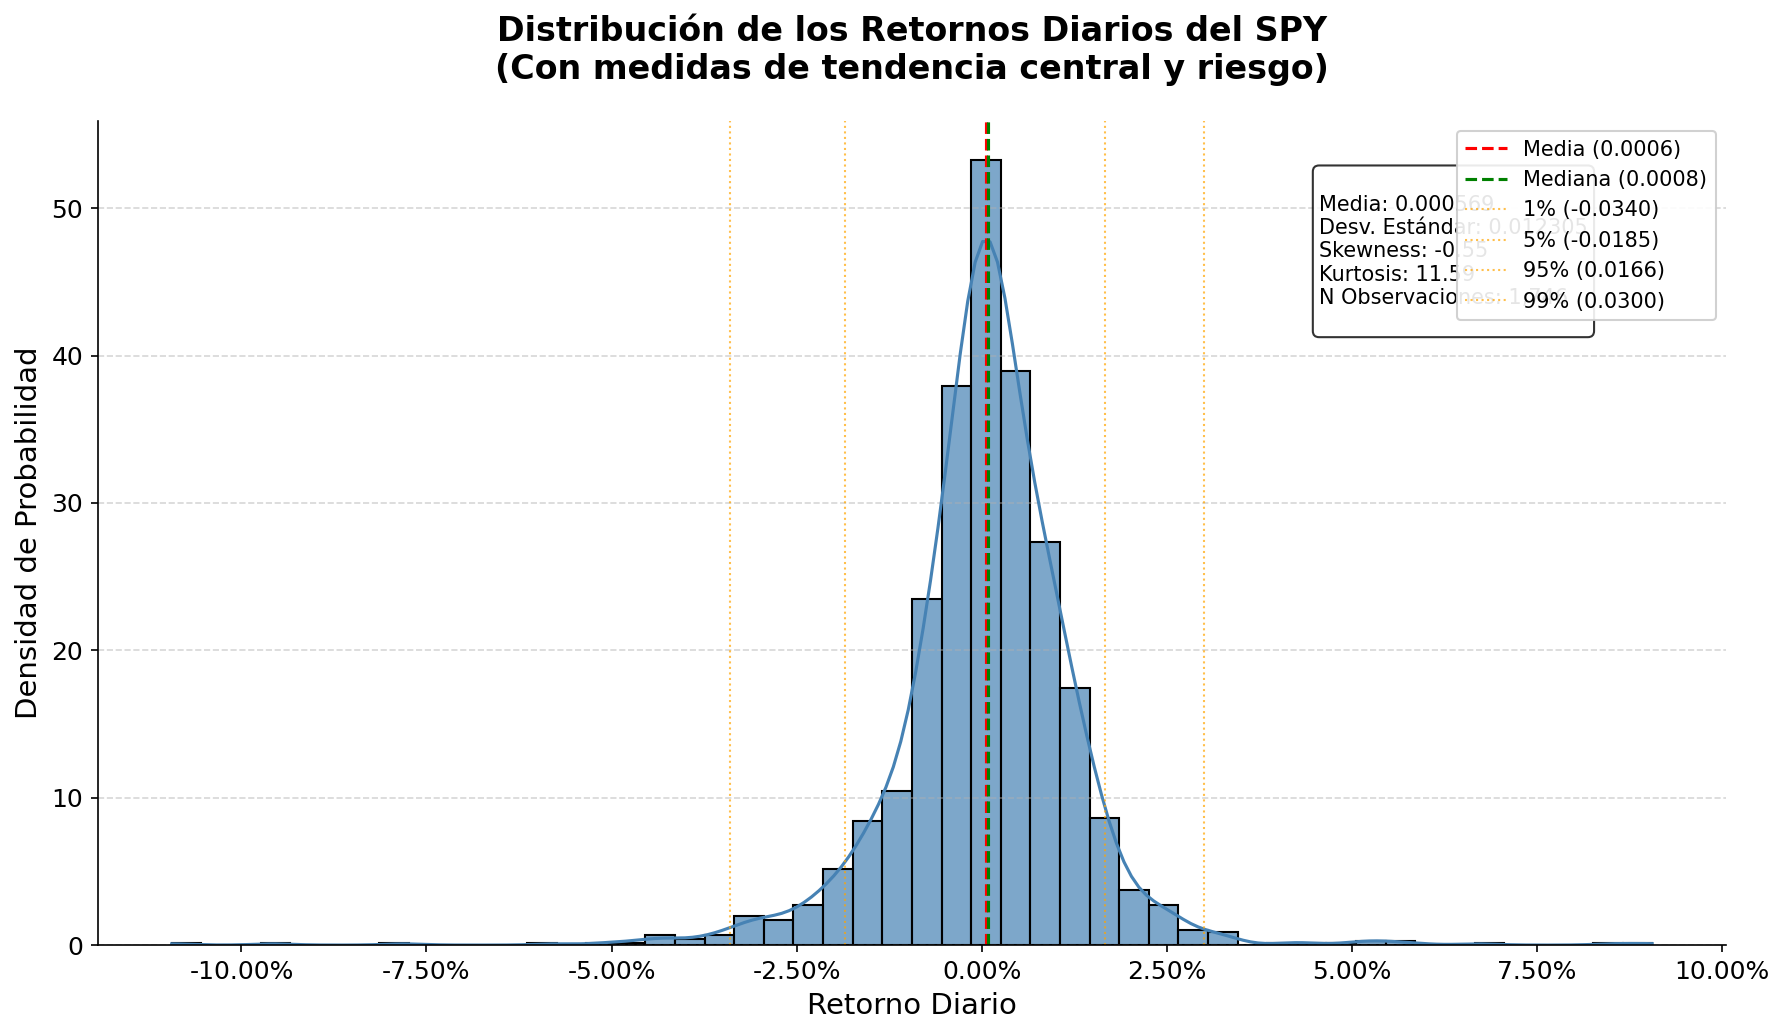

In [78]:
plt.figure(figsize=(12, 7), dpi=150)

# Histograma con mejoras
hist = sns.histplot(final_data['daily_return'], bins=50, kde=True, 
                   color='steelblue', edgecolor='black',
                   alpha=0.7, stat='density')  # density para comparar con KDE

# Líneas de referencia importantes
plt.axvline(x=final_data['daily_return'].mean(), color='red', linestyle='--', 
           linewidth=1.5, label=f'Media ({final_data["daily_return"].mean():.4f})')
plt.axvline(x=final_data['daily_return'].median(), color='green', linestyle='--', 
           linewidth=1.5, label=f'Mediana ({final_data["daily_return"].median():.4f})')

# Añadir líneas para percentiles importantes (riesgo)
for percentile in [1, 5, 95, 99]:
    pct_value = final_data['daily_return'].quantile(percentile/100)
    plt.axvline(x=pct_value, color='orange', linestyle=':', 
               linewidth=1, alpha=0.7, 
               label=f'{percentile}% ({pct_value:.4f})')

plt.title('Distribución de los Retornos Diarios del SPY\n(Con medidas de tendencia central y riesgo)', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Retorno Diario', fontsize=14)
plt.ylabel('Densidad de Probabilidad', fontsize=14)  # Cambiado por stat='density'

# Formatear ejes para porcentajes
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2%}'))

# Leyenda y estilo
plt.legend(fontsize=10, framealpha=0.9)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cuadrícula y estilo
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

# Añadir texto con estadísticas clave
stats_text = f"""
Media: {final_data['daily_return'].mean():.6f}
Desv. Estándar: {final_data['daily_return'].std():.6f}
Skewness: {final_data['daily_return'].skew():.2f}
Kurtosis: {final_data['daily_return'].kurtosis():.2f}
N Observaciones: {len(final_data):,}
"""
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', 
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# explicacion

## 6.3 Matriz de correlación

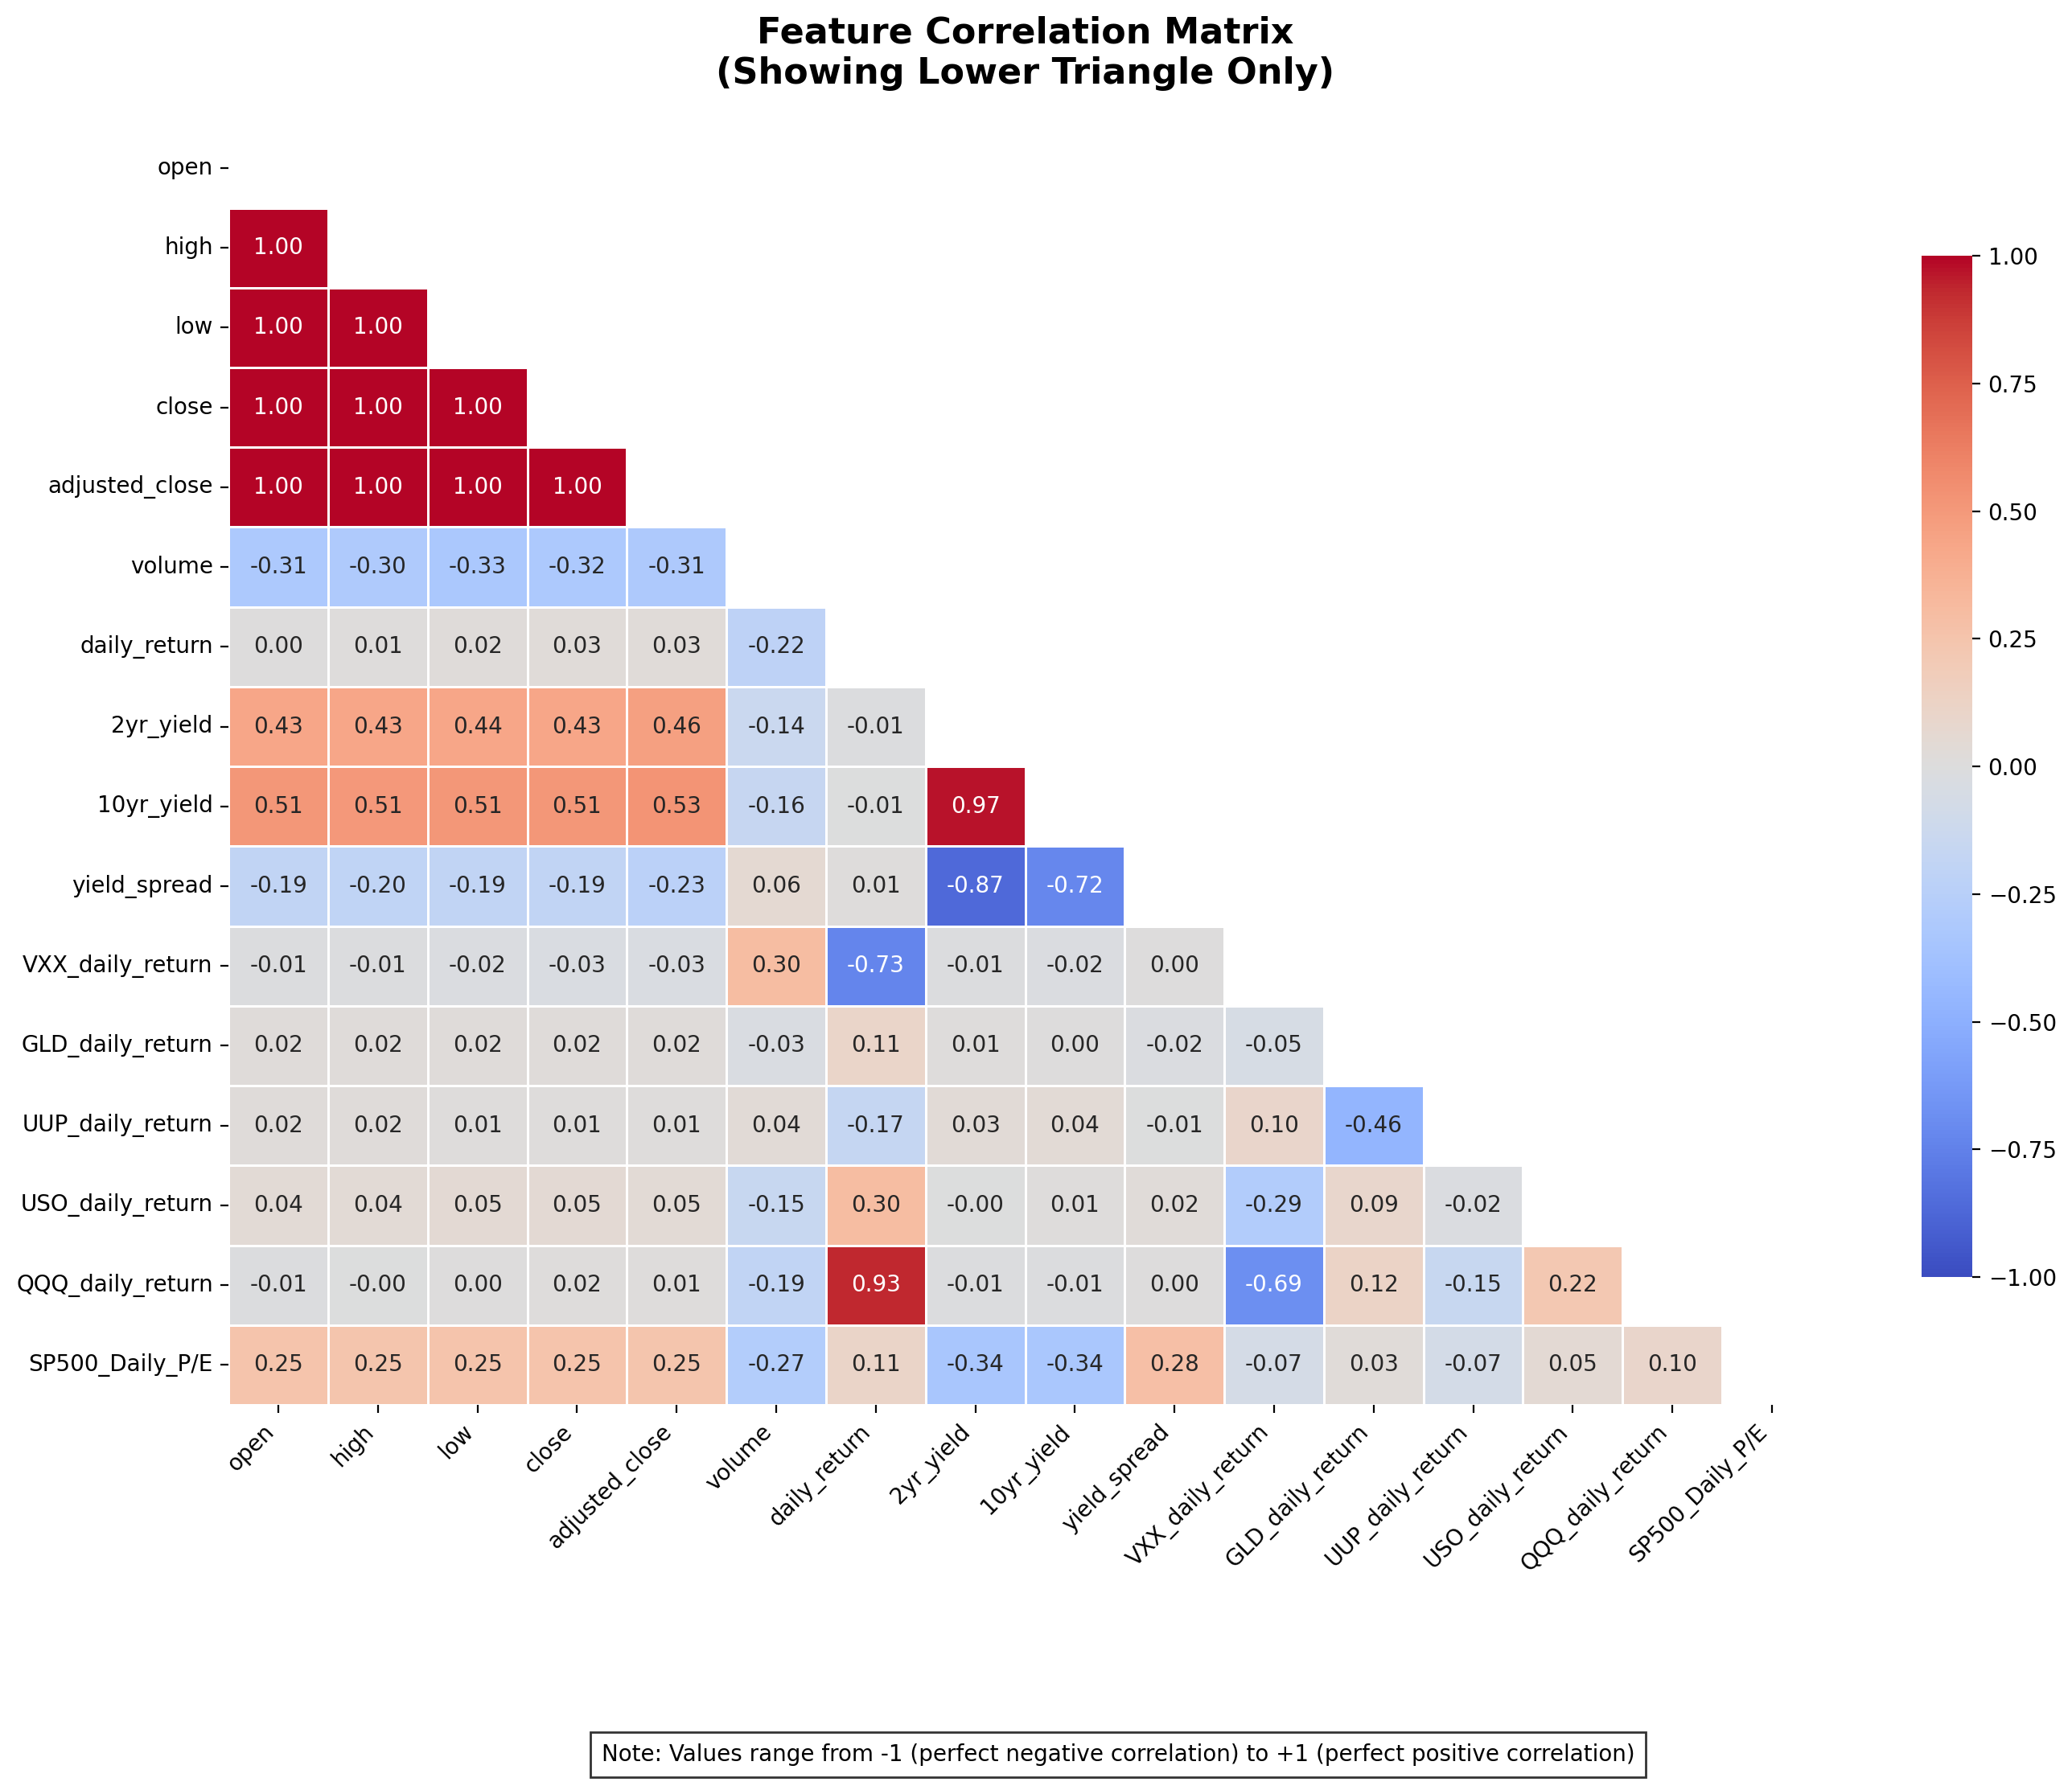

In [79]:
df = final_data
numeric_df = df.select_dtypes(include=['number', 'float', 'int'])  # More comprehensive numeric selection

plt.figure(figsize=(14, 10), dpi=200)
correlation_matrix = numeric_df.corr()

# Create mask for upper triangle to avoid redundancy
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Enhanced heatmap with better styling
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f',
            center=0,
            vmin=-1, 
            vmax=1,
            linewidths=0.5,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.8})

plt.title('Feature Correlation Matrix\n(Showing Lower Triangle Only)', 
         fontsize=16, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Add explanatory note
plt.figtext(0.5, -0.1, 
           "Note: Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)",
           ha="center", 
           fontsize=10,
           bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout()
plt.show()

## 6.4. Key par plot

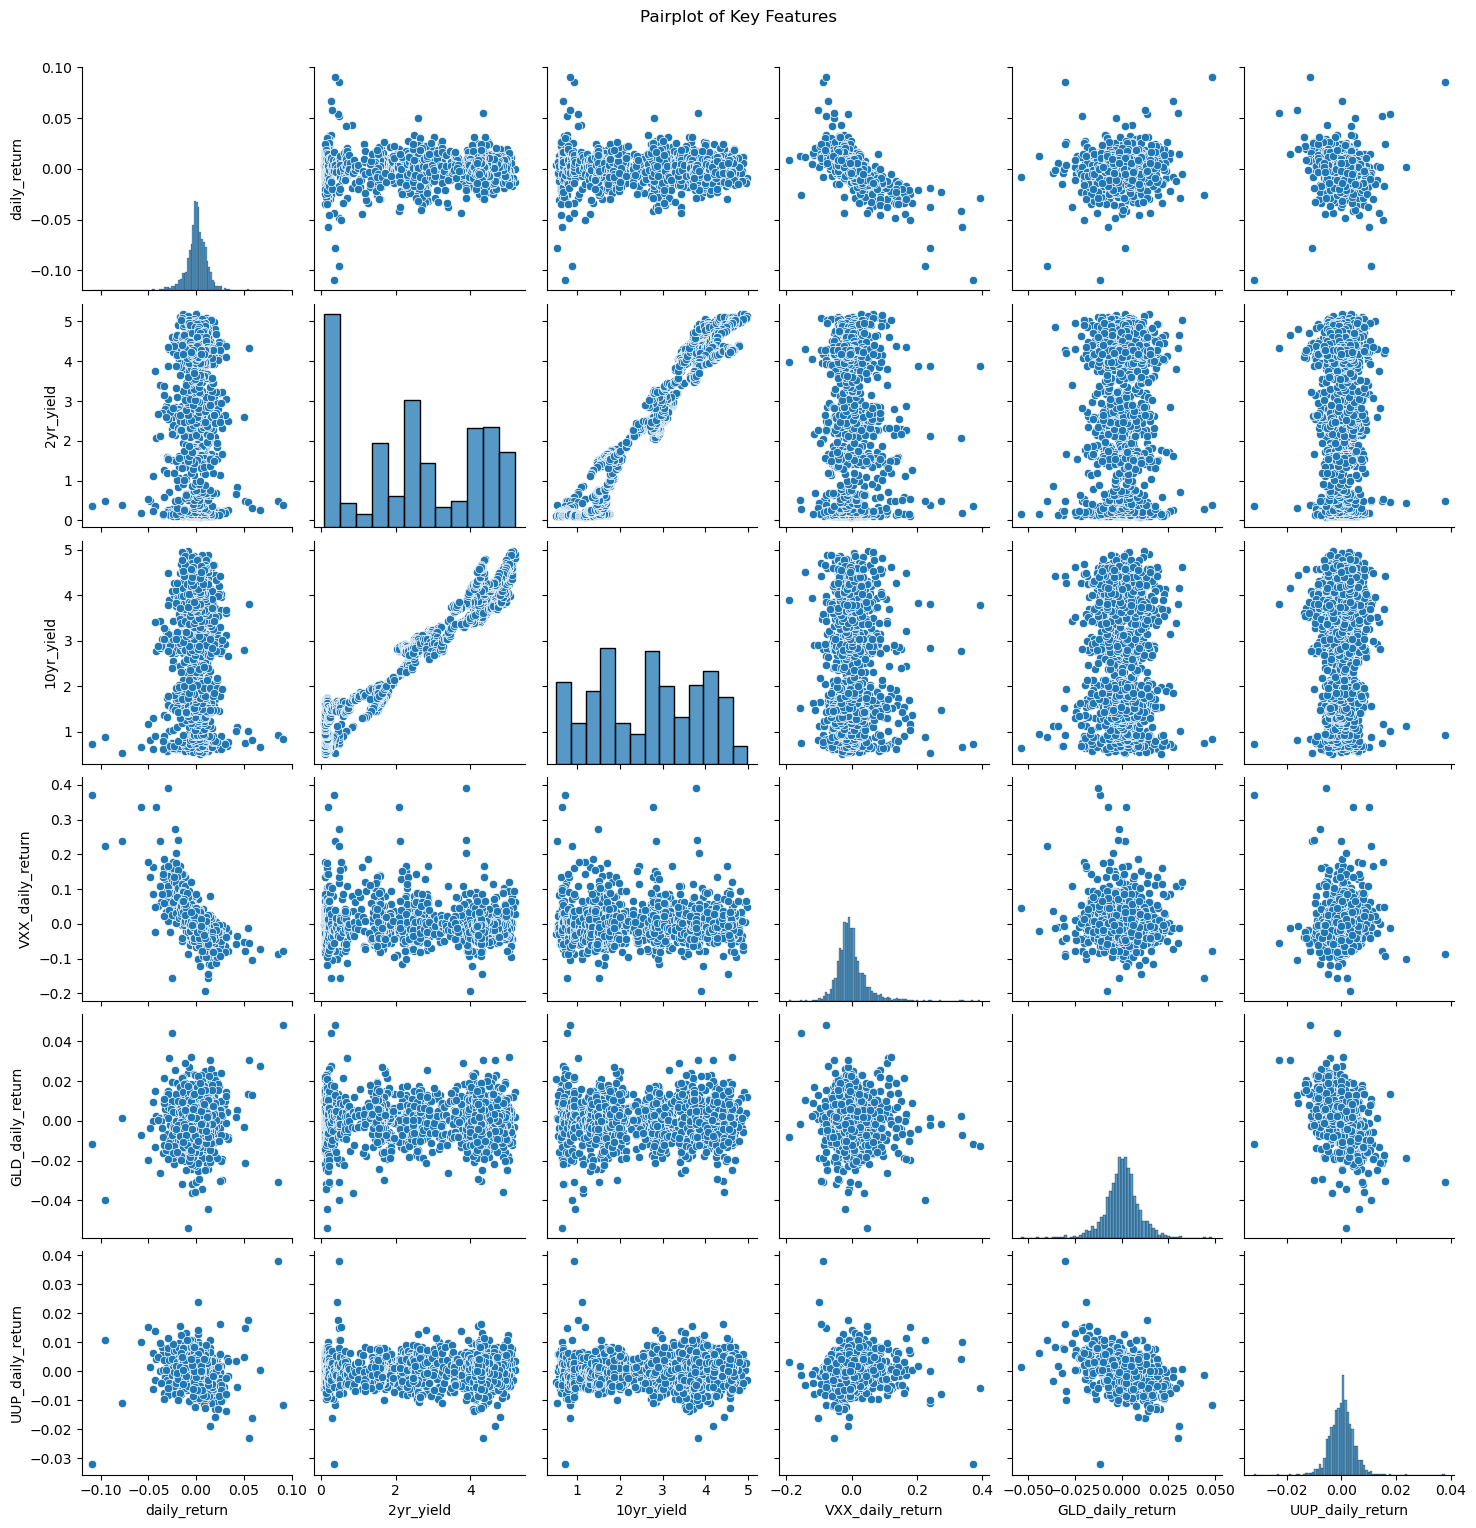

In [81]:
sns.pairplot(final_data[['daily_return', '2yr_yield', '10yr_yield', 'VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return']])
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()


# 7. Extracción de características

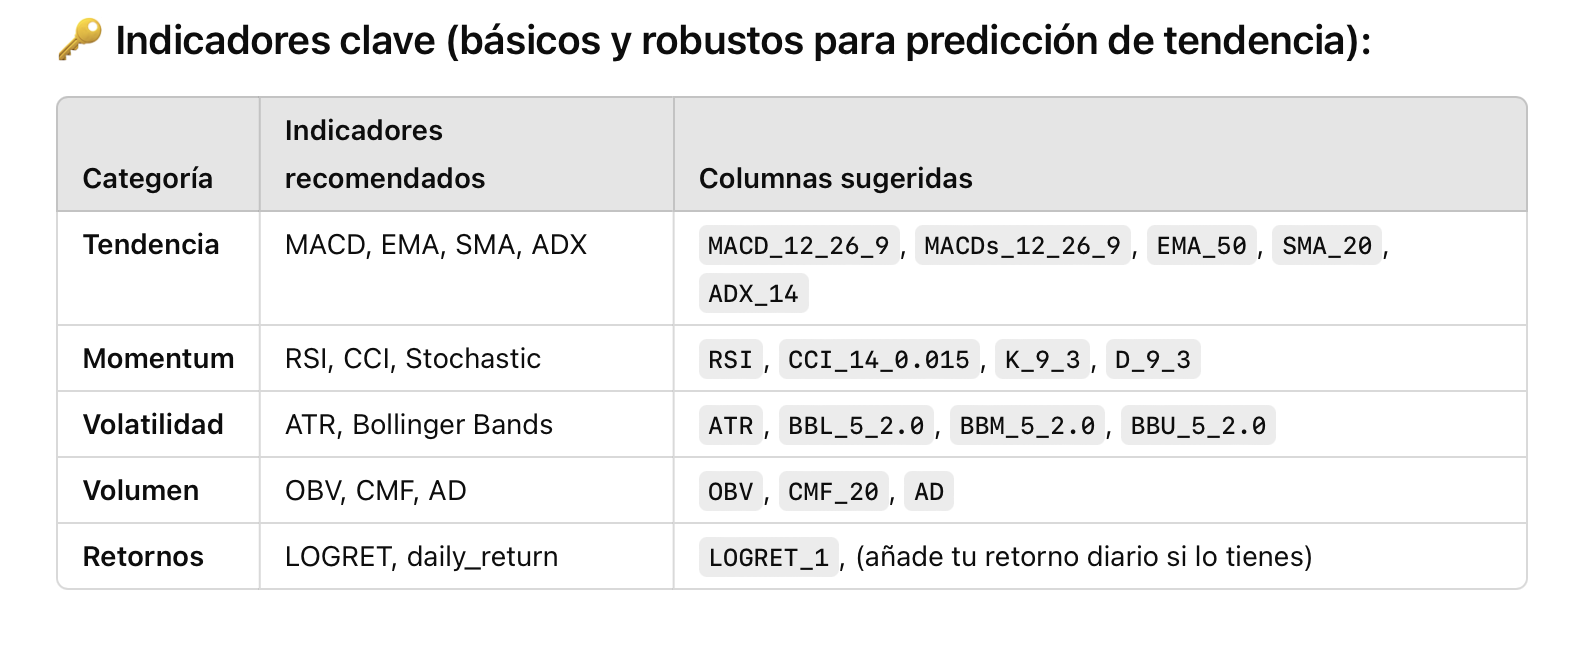

In [89]:
pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.


In [90]:
import pandas as pd
import pandas_ta as ta


In [117]:
import pandas_ta as ta

# Crea los indicadores y agrégalos al DataFrame
ohlcv_data = final_data[['open', 'high', 'low', 'close', 'volume']].copy()
ohlcv_data



,open,high,low,close,volume
date,,,,,
2018-02-02,280.079987,280.230011,275.410004,275.450012,173174800
2018-02-05,273.450012,275.850006,263.309998,263.929993,294681800
2018-02-06,259.940002,269.700012,258.700012,269.130005,355026800
2018-02-07,268.500000,272.359985,267.579987,267.670013,167376100
2018-02-08,268.010010,268.170013,257.589996,257.630005,246449500
...,...,...,...,...,...
2025-01-27,594.809998,599.690002,594.640015,599.369995,70361100
2025-01-28,600.619995,605.369995,597.250000,604.520020,44433300
2025-01-29,603.719971,604.130005,599.219971,601.809998,37177400


In [99]:
pip install TA-Lib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [64 lines of output]
      <string>:83: UserWarning: Cannot find ta-lib library, installation may fail.
      /private/var/folders/b5/s20nyjcd1vb6cdch4y6lscbr0000gn/T/pip-build-env-wlzyaa82/overlay/lib/python3.10/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsWarning: `install_requires` overwritten in `pyproject.toml` (dependencies)
        corresp(dist, value, root_dir)
      /private/var/folders/b5/s20nyjcd1vb6cdch4y6lscbr0000gn/T/pip-build-env-wlzyaa82/overlay/lib/python3.10/site-packages/setuptools/config/_apply_pyprojecttoml.py:61: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ***********************

In [101]:
df = ohlcv_data

import pandas_ta as ta

df['RSI'] = df.ta.rsi()
df[['MACD', 'MACD_signal', 'MACD_hist']] = df.ta.macd()
df['SMA_20'] = df.ta.sma(length=20)
df['EMA_50'] = df.ta.ema(length=50)
df['ATR'] = df.ta.atr()
df['OBV'] = df.ta.obv()
df['ADX'] = df.ta.adx()['ADX_14']  # puedes cambiar el length


In [111]:
a = df.columns
a

Index(['open', 'high', 'low', 'close', 'volume', 'ABER_ZG_5_15',
       'ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15', 'ACCBL_20',
       ...
       'MACDs_12_26_9', 'MAD_30', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist',
       'SMA_20', 'EMA_50', 'ATR', 'ADX'],
      dtype='object', length=124)

In [112]:
print(df.columns.tolist())

['open', 'high', 'low', 'close', 'volume', 'ABER_ZG_5_15', 'ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15', 'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'AD', 'ADOSC_3_10', 'ADX_14', 'DMP_14', 'DMN_14', 'ALMA_10_6.0_0.85', 'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2', 'AO_5_34', 'OBV', 'OBV_min_2', 'OBV_max_2', 'OBVe_4', 'OBVe_12', 'AOBV_LR_2', 'AOBV_SR_2', 'APO_12_26', 'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'ATRr_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BIAS_SMA_26', 'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CDL_DOJI_10_0.1', 'CDL_INSIDE', 'open_Z_30_1', 'high_Z_30_1', 'low_Z_30_1', 'close_Z_30_1', 'CFO_9', 'CG_10', 'CHOP_14_1_100', 'CKSPl_10_3_20', 'CKSPs_10_3_20', 'CMF_20', 'CMO_14', 'COPC_11_14_10', 'CTI_12', 'LDECAY_5', 'DEC_1', 'DEMA_10', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'DPO_20', 'EBSW_40_10', 'EFI_13', 'EMA_10', 'ENTP_10', 'EOM_14_100000000', 'ER_10', 'BULLP_13', 'BEARP_13', 'FISHERT_9_1', 'FISHERTs_9_1', 'FWMA_10', 'HA_open', 'HA_high', 'HA_low', 'HA_close

In [113]:
keep_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9',
    'RSI', 'CCI_14_0.015', 'K_9_3', 'D_9_3',
    'SMA_20', 'EMA_50',
    'ADX_14', 'ATR',
    'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
    'OBV', 'CMF_20', 'AD',
    'LOGRET_1'  # o daily_return si lo tienes
]

df = df[keep_cols]


In [115]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'MACD_12_26_9',
       'MACDs_12_26_9', 'MACDh_12_26_9', 'RSI', 'CCI_14_0.015', 'K_9_3',
       'D_9_3', 'SMA_20', 'EMA_50', 'ADX_14', 'ATR', 'BBL_5_2.0', 'BBM_5_2.0',
       'BBU_5_2.0', 'OBV', 'CMF_20', 'AD', 'LOGRET_1'],
      dtype='object')

In [119]:
final_data.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'daily_return', '2yr_yield', '10yr_yield', 'yield_spread',
       'VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return',
       'USO_daily_return', 'QQQ_daily_return', 'SP500_Daily_P/E'],
      dtype='object')

In [ ]:
df = df.add_suffix('_tech')

In [124]:
df.columns

Index(['open_tech', 'high_tech', 'low_tech', 'close_tech', 'volume_tech',
       'MACD_12_26_9_tech', 'MACDs_12_26_9_tech', 'MACDh_12_26_9_tech',
       'RSI_tech', 'CCI_14_0.015_tech', 'K_9_3_tech', 'D_9_3_tech',
       'SMA_20_tech', 'EMA_50_tech', 'ADX_14_tech', 'ATR_tech',
       'BBL_5_2.0_tech', 'BBM_5_2.0_tech', 'BBU_5_2.0_tech', 'OBV_tech',
       'CMF_20_tech', 'AD_tech', 'LOGRET_1_tech'],
      dtype='object')

In [127]:
# Merge the technical indicators back into the original DataFrame
data = final_data.join(df, how='outer', rsuffix='_tech')
data.drop(columns=['open_tech', 'high_tech', 'low_tech', 'close_tech', 'volume_tech'])

,open,high,low,close,adjusted_close,volume,daily_return,2yr_yield,10yr_yield,yield_spread,...,EMA_50_tech,ADX_14_tech,ATR_tech,BBL_5_2.0_tech,BBM_5_2.0_tech,BBU_5_2.0_tech,OBV_tech,CMF_20_tech,AD_tech,LOGRET_1_tech
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,280.079987,280.230011,275.410004,275.450012,245.220901,173174800,-0.021770,2.15,2.84,0.69,...,NaN,NaN,NaN,NaN,NaN,NaN,1.731748e+08,NaN,-1.702999e+08,NaN
2018-02-05,273.450012,275.850006,263.309998,263.929993,234.965195,294681800,-0.041822,2.08,2.77,0.69,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.215070e+08,NaN,-4.358428e+08,-0.042722
2018-02-06,259.940002,269.700012,258.700012,269.130005,239.594543,355026800,0.019702,2.10,2.79,0.69,...,NaN,NaN,NaN,NaN,NaN,NaN,2.335198e+08,NaN,-1.176101e+08,0.019511
2018-02-07,268.500000,272.359985,267.579987,267.670013,238.294693,167376100,-0.005425,2.15,2.84,0.69,...,NaN,NaN,NaN,NaN,NaN,NaN,6.614370e+07,NaN,-2.786815e+08,-0.005440
2018-02-08,268.010010,268.170013,257.589996,257.630005,229.356552,246449500,-0.037509,2.13,2.85,0.72,...,NaN,NaN,NaN,254.986536,266.762006,278.537475,-1.803058e+08,NaN,-5.232671e+08,-0.038230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27,594.809998,599.690002,594.640015,599.369995,597.572388,70361100,-0.014145,4.17,4.53,0.36,...,592.994921,22.641554,7.181350,597.915608,605.315991,612.716374,1.183640e+09,0.138789,8.997698e+09,-0.014246
2025-01-28,600.619995,605.369995,597.250000,604.520020,602.706970,44433300,0.008592,4.19,4.55,0.36,...,593.446886,21.248528,7.248396,598.481257,605.609998,612.738738,1.228073e+09,0.153166,9.032829e+09,0.008556
2025-01-29,603.719971,604.130005,599.219971,601.809998,600.005066,37177400,-0.004483,4.21,4.55,0.34,...,593.774851,19.955004,7.109229,597.042668,604.683997,612.325326,1.190896e+09,0.145794,9.034874e+09,-0.004493


In [129]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'daily_return', '2yr_yield', '10yr_yield', 'yield_spread',
       'VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return',
       'USO_daily_return', 'QQQ_daily_return', 'SP500_Daily_P/E', 'open_tech',
       'high_tech', 'low_tech', 'close_tech', 'volume_tech',
       'MACD_12_26_9_tech', 'MACDs_12_26_9_tech', 'MACDh_12_26_9_tech',
       'RSI_tech', 'CCI_14_0.015_tech', 'K_9_3_tech', 'D_9_3_tech',
       'SMA_20_tech', 'EMA_50_tech', 'ADX_14_tech', 'ATR_tech',
       'BBL_5_2.0_tech', 'BBM_5_2.0_tech', 'BBU_5_2.0_tech', 'OBV_tech',
       'CMF_20_tech', 'AD_tech', 'LOGRET_1_tech'],
      dtype='object')

## Choosing the Threshold

In [133]:
data["daily_return"].describe()

count    1746.000000
mean        0.000569
std         0.012305
min        -0.109424
25%        -0.004481
50%         0.000801
75%         0.006696
max         0.090603
Name: daily_return, dtype: float64

Aquí obtenemos un estadístico muy simle pero a la vez muy exlicativo. Vemos que la media de las ganancias es de 0.0005 = 0.05% diario.
Eso es más de 15% anual si se acumula

La desviación standard nos indica cuanto puede moverse el indice en un día hacia arriba o abajo. Es decir, nos indica la volatilidad de nuestro activo.

75% = +0.669% (0.006696)
Este es el tercer cuartil:

El 25% de los días el SPY subió más de +0.669%.
Es decir, solo 1 de cada 4 días el retorno fue tan bueno o mejor que eso.

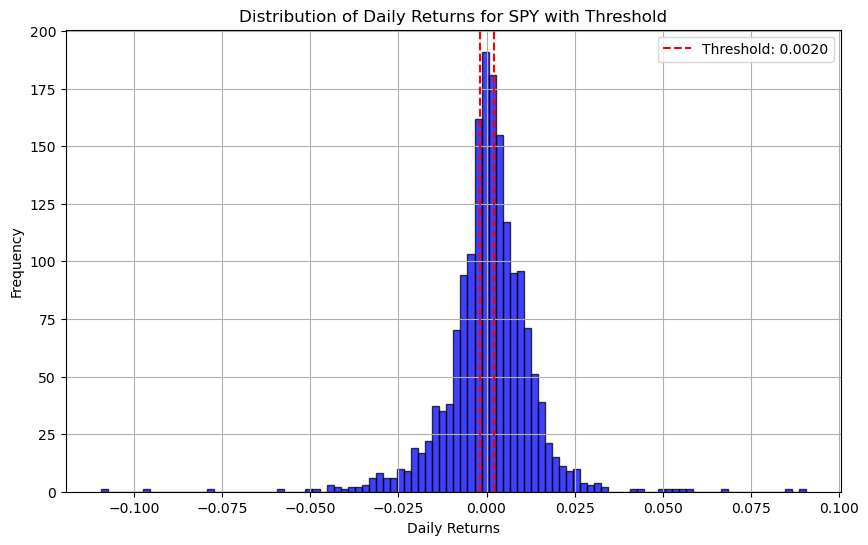

In [136]:
threshold = 0.0020 
plt.figure(figsize=(10, 6))
plt.hist(data['daily_return'], bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.axvline(x=-threshold, color='red', linestyle='--')
plt.title('Distribution of Daily Returns for SPY with Threshold')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Target Labling

In [137]:
# 1. Define the Target (Label) Using Threshold
threshold = 0.0020  # Define your threshold (0.20%)
data['Target'] = np.where(data['daily_return'] > threshold, 1, 0)

# 2. Backfill missing values to address missing data
data = data.bfill(axis=1)

# 3. Remove any remaining rows with NaN values (if needed)
data.dropna(inplace=True)

# 4. Check for missing values to ensure they're handled
print(data.isna().sum())

open                  0
high                  0
low                   0
close                 0
adjusted_close        0
volume                0
daily_return          0
2yr_yield             0
10yr_yield            0
yield_spread          0
VXX_daily_return      0
GLD_daily_return      0
UUP_daily_return      0
USO_daily_return      0
QQQ_daily_return      0
SP500_Daily_P/E       0
open_tech             0
high_tech             0
low_tech              0
close_tech            0
volume_tech           0
MACD_12_26_9_tech     0
MACDs_12_26_9_tech    0
MACDh_12_26_9_tech    0
RSI_tech              0
CCI_14_0.015_tech     0
K_9_3_tech            0
D_9_3_tech            0
SMA_20_tech           0
EMA_50_tech           0
ADX_14_tech           0
ATR_tech              0
BBL_5_2.0_tech        0
BBM_5_2.0_tech        0
BBU_5_2.0_tech        0
OBV_tech              0
CMF_20_tech           0
AD_tech               0
LOGRET_1_tech         0
Target                0
dtype: int64


In [140]:
data["Target"].value_counts()

Target
0.0    975
1.0    771
Name: count, dtype: int64

Podemos ver que las dos clases no estan tan desbalanceados, eso nos facilitará bastante le trabajo. De todas formas, podemos calcular un peso para cada clase para simular la igualdad entre estas. Que posteriormente podemos usar o no.

In [ ]:
# Class Imbalance Handling
def cwts(dfs):
    c0, c1 = np.bincount(dfs['Target'])
    w0 = (1/c0) * (len(dfs)) / 2
    w1 = (1/c1) * (len(dfs)) / 2
    return {0: w0, 1: w1}

class_weight = cwts(data)
print(f"Class Weights: {class_weight}")

## Normalización de los datos y selección de Características

Aplicamos un análisis de correlación entre todas las variables del dataset para identificar y eliminar aquellas que están altamente correlacionadas entre sí, con el fin de evitar la multicolinealidad.

In [187]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='Target')
y = data['Target'].astype(int)  # Ensure y is of integer type
y.to_csv('target_spy.csv')

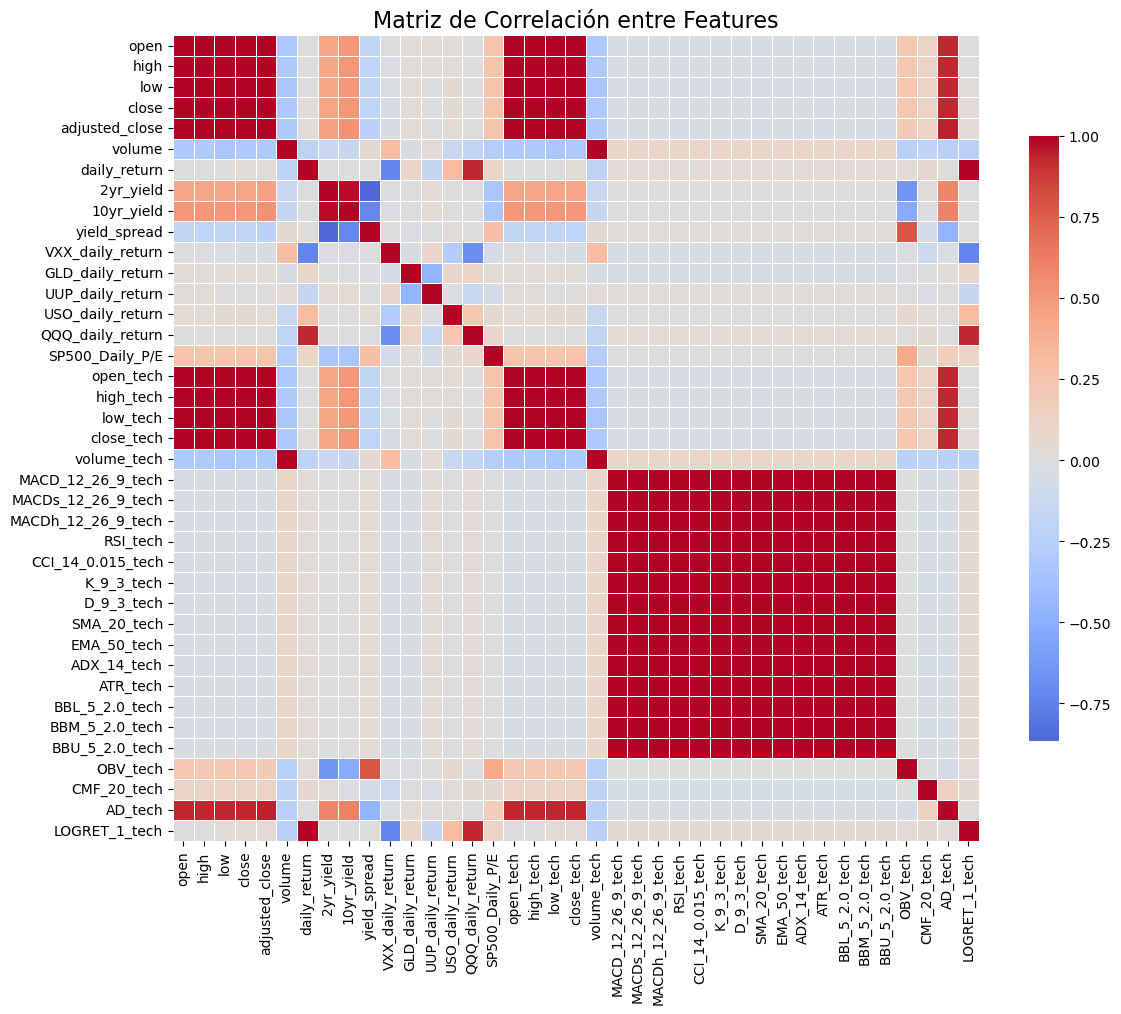

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de estar trabajando con un DataFrame limpio (por ejemplo, df_reduced si ya filtraste por correlación)
# Si aún no lo hiciste, simplemente usa df

# 1. Calcular la matriz de correlación
corr_matrix = X.corr()

# 2. Configurar el tamaño del gráfico
plt.figure(figsize=(12, 10))

# 3. Crear el heatmap
sns.heatmap(corr_matrix, 
            annot=False,        # Cambia a True si quieres ver los números
            cmap='coolwarm',    # Escala de colores
            center=0,           # El punto medio del color
            square=True, 
            linewidths=0.5,
            cbar_kws={"shrink": .75})

# 4. Título del gráfico
plt.title('Matriz de Correlación entre Features', fontsize=16)
plt.tight_layout()
plt.show()


Observamos que muchas variables presentaban una alta correlación entre sí, lo que indica redundancia y ausencia de información nueva. Por ello, decidimos eliminar aquellas cuyo coeficiente de correlación fuera superior a 0.95. Este umbral es ampliamente utilizado en la práctica, ya que permite reducir significativamente la dimensionalidad del dataset manteniendo un buen equilibrio entre limpieza y retención de información relevante.

In [166]:
import numpy as np
import pandas as pd

# Supongamos que tu DataFrame de entrada es df
# Si ya está escalado, no pasa nada

# 1. Calcular la matriz de correlación absoluta
corr_matrix = X.corr().abs()

# 2. Tomar solo la mitad superior (para evitar duplicados)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Encontrar columnas con correlación mayor a 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# 4. Eliminar esas columnas del DataFrame
df_reduced = X.drop(columns=to_drop)

print(f"Se eliminaron {len(to_drop)} columnas altamente correlacionadas:")
print(to_drop)


Se eliminaron 24 columnas altamente correlacionadas:
['high', 'low', 'close', 'adjusted_close', '10yr_yield', 'open_tech', 'high_tech', 'low_tech', 'close_tech', 'volume_tech', 'MACDs_12_26_9_tech', 'MACDh_12_26_9_tech', 'RSI_tech', 'CCI_14_0.015_tech', 'K_9_3_tech', 'D_9_3_tech', 'SMA_20_tech', 'EMA_50_tech', 'ADX_14_tech', 'ATR_tech', 'BBL_5_2.0_tech', 'BBM_5_2.0_tech', 'BBU_5_2.0_tech', 'LOGRET_1_tech']


In [173]:
len(df_reduced.columns.to_list())

15

In [176]:
df_reduced.columns

Index(['open', 'volume', 'daily_return', '2yr_yield', 'yield_spread',
       'VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return',
       'USO_daily_return', 'QQQ_daily_return', 'SP500_Daily_P/E',
       'MACD_12_26_9_tech', 'OBV_tech', 'CMF_20_tech', 'AD_tech'],
      dtype='object')

### Variables seleccionadas tras la eliminación de multicolinealidad

1. **`open`**  
   Precio de apertura del SPY en ese día. Indica a qué nivel comenzó a cotizar el ETF ese día de mercado.

2. **`volume`**  
   Cantidad total de acciones del SPY negociadas durante el día. Puede reflejar presión de compra o venta.

3. **`daily_return`**  
   Retorno porcentual diario del SPY respecto al cierre del día anterior. Es una medida directa de ganancia o pérdida diaria.

4. **`2yr_yield`**  
   Rendimiento del bono del Tesoro de EE.UU. a 2 años. Representa expectativas de tipos de interés a corto plazo.

5. **`yield_spread`**  
   Diferencia entre el rendimiento del bono a 10 años y el de 2 años. Indicador clásico de posibles recesiones o tensiones macroeconómicas.

6. **`VXX_daily_return`**  
   Retorno diario del VXX (índice de volatilidad). Aumenta cuando el mercado espera alta volatilidad; suele correlacionarse negativamente con el SPY.

7. **`GLD_daily_return`**  
   Retorno diario del ETF de oro (GLD). El oro actúa como activo refugio y puede moverse en sentido opuesto al mercado.

8. **`UUP_daily_return`**  
   Retorno diario del ETF que sigue al dólar estadounidense (UUP). Indica fortaleza del dólar, que puede afectar activos globales.

9. **`USO_daily_return`**  
   Retorno diario del ETF de petróleo crudo (USO). El petróleo se relaciona con inflación y actividad económica.

10. **`QQQ_daily_return`**  
    Retorno diario del ETF tecnológico QQQ. Muy correlacionado con el SPY, pero más sensible al sector tecnológico.

11. **`SP500_Daily_P/E`**  
    Relación precio-beneficio diaria ajustada del S&P 500. Puede indicar si el mercado está sobrevalorado o infravalorado.

12. **`MACD_12_26_9_tech`**  
    Indicador técnico de momentum basado en medias móviles (MACD). Captura cambios en la tendencia de precios.

13. **`OBV_tech`**  
    On-Balance Volume. Combina precio y volumen para detectar presión de compra o venta acumulativa.

14. **`CMF_20_tech`**  
    Chaikin Money Flow. Mide el flujo de dinero hacia/desde un activo, integrando volumen y precio durante 20 días.

15. **`AD_tech`**  
    Acumulación/Distribución Line. Evalúa si un activo está siendo acumulado (comprado) o distribuido (vendido) en base a volumen y precios de cierre.


In [ ]:
df_reduced.to_excel('SPY_Daily_Data_Reduced.xlsx')

## 5 - Preparación de datos para el modelo

In [ ]:
df_reduced = pd.read_excel('SPY_Daily_Data_Reduced.xlsx')
y = pd.read_excel('target_spy.xlsx')

In [189]:
y

,date,Target
0,2018-02-02,0
1,2018-02-05,0
2,2018-02-06,1
3,2018-02-07,0
4,2018-02-08,0
...,...,...
1741,2025-01-27,0
1742,2025-01-28,1
1743,2025-01-29,0
1744,2025-01-30,1


In [186]:
df_reduced.dtypes

date                 datetime64[ns]
open                        float64
volume                        int64
daily_return                float64
2yr_yield                   float64
yield_spread                float64
VXX_daily_return            float64
GLD_daily_return            float64
UUP_daily_return            float64
USO_daily_return            float64
QQQ_daily_return            float64
SP500_Daily_P/E             float64
MACD_12_26_9_tech           float64
OBV_tech                      int64
CMF_20_tech                 float64
AD_tech                     float64
dtype: object

Una vez finalizado el proceso de selección de variables, y tras haber reducido el dataset a un conjunto compacto y no redundante de características relevantes, procedemos a dividir los datos en conjuntos de entrenamiento (train) y prueba (test), dejando el 30% de los datos para el conjunto de prueba. Posteriormente, aplicamos una transformación de escalado mediante MinMaxScaler, que normaliza cada variable en un rango entre 0 y 1.

IMPORTANTE: al dividir tener el shuffle en FALSE ya que tenemos que respetar el orden secuencial de la serie temporal...

In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_reduced, y, test_size=0.3, shuffle=False)


In [182]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # aprende los valores mínimos/máximos
X_test_scaled = scaler.transform(X_test)        # aplica esos mismos valores al test
